In [62]:
import pandas as pd

df = pd.read_csv('../data/museum_data_mean_target_encoding.csv')
df.drop(['Unnamed: 0', 'Object Begin Date'], axis=1, inplace=True)
df.head()

,Historical Period,height,diam,width,depth,num_period,medium_num,classif_num,culture_num
0,Modern Times,296.50,-1.0,261.60,-1.0,2.0,1.854215,1.966078,1.656506
1,Modern Times,12.07,-1.0,11.43,-1.0,2.0,2.927883,2.295775,2.000000
2,Contemporary Era,-1.00,-1.0,-1.00,105.5,1.0,1.666667,1.981467,1.871935
3,Modern Times,-1.00,-1.0,-1.00,14.5,2.0,1.914692,2.295775,1.886682
4,Modern Times,-1.00,8.3,-1.00,-1.0,2.0,2.166667,1.848797,1.871935


### Preprocessing

#### Get X and y

In [74]:
""" from sklearn.preprocessing import OneHotEncoder
import numpy as np

periods = np.array(df["Historical Period"]).reshape(-1, 1)

ohe = OneHotEncoder(sparse=False)
ohe.fit(periods)
y = ohe.transform(periods)

# key: name of the class; item: index of the column in y
dico_classes_column = {"Modern Times":3, "Contemporary Era":1, "Antiquity":0, "Middle Ages":2}"""


map_period = {"Contemporary Era":1., "Modern Times": 2., "Middle Ages":3., "Antiquity":4.}

In [64]:
import numpy as np
y = np.array(df["num_period"])
y

array([2., 2., 1., ..., 1., 4., 4.])

In [65]:
X = np.array(df.drop(columns=["Historical Period", "num_period"]))
X.shape

(106699, 7)

#### Split data into training and testing sets

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_train, n_test = len(X_train), len(X_test)
print("Nb of training samples:", n_train)
print("Nb of testing samples:", n_test)

Nb of training samples: 85359
Nb of testing samples: 21340


In [75]:
# check classes proportions in train and test
prop_classes_train = {class_name: np.mean(y_train == id) for (class_name,id) in map_period.items()}
prop_classes_test = {class_name: np.mean(y_test == id) for (class_name,id) in map_period.items()}
prop_classes_train

{'Contemporary Era': 0.16006513665811456,
 'Modern Times': 0.5419697981466512,
 'Middle Ages': 0.12558722571726472,
 'Antiquity': 0.17237783947796953}

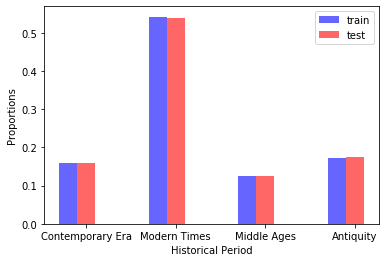

In [76]:
import matplotlib.pyplot as plt
# create data
x = np.arange(4)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, prop_classes_train.values(), width, color='blue', alpha=0.6)
plt.bar(x, prop_classes_test.values(), width, color='red', alpha=0.6)

plt.xticks(x, prop_classes_train.keys())
plt.xlabel("Historical Period")
plt.ylabel("Proportions")
plt.legend(["train", "test"])
plt.show()

#### Rescaling the features

medium_num, culture_num and classif_num are bounded between 1 and 4 by construction (fine).


Let's transform the features related to dimensions: height, width, depth and diam. It doesn't really make sense (from a physical point of view) to normalize them to zero mean and unit variance. Instead, let's rescale them so that they are between 0 and 1:

In [77]:
X_train[0,:]

array([ 7.5       , -1.        ,  6.3       ,  0.4       ,  2.78070175,
        2.4606599 ,  2.05070831])

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[:,:4])
dims_train_minmax = scaler.transform(X_train[:,:4])

In [79]:
# check
print(np.min(dims_train_minmax, axis=0), np.max(dims_train_minmax, axis=0))

[0. 0. 0. 0.] [1. 1. 1. 1.]


In [80]:
X_train[:,:4] = dims_train_minmax
print(X_train[0,:])

[3.56618418e-03 0.00000000e+00 3.65914787e-03 1.02805111e-03
 2.78070175e+00 2.46065990e+00 2.05070831e+00]


In [81]:
# apply the same transformation on testing set
dims_test_minmax = scaler.transform(X_test[:,:4])
X_test[:,:4] = dims_test_minmax
X_test[0,:]

array([0.00482484, 0.        , 0.00526316, 0.        , 1.72804054,
       1.80503145, 1.88668192])

### Machine Learning models

#### Baseline Multinomial Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=0, multi_class="multinomial")
logit.fit(X_train, y_train)

/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [102]:

def plot_confusion_matrix(model, X_test, y_test, model_name=""):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    preds = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, cmap="Blues",
    annot=True, xticklabels=map_period.keys(),
    yticklabels=map_period.keys(),
    )
    plt.title("Confusion matrix of {}".format(model_name))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

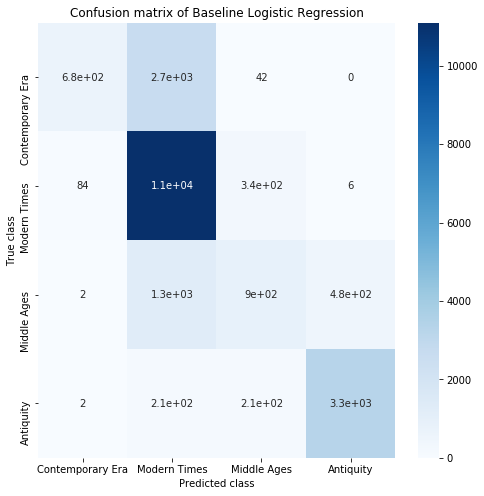

In [103]:
plot_confusion_matrix(logit, X_test, y_test, model_name="Baseline Logistic Regression")

#### Tuned Multinomial Logistic Regression

In [113]:
from sklearn.model_selection import GridSearchCV

grid_params = {"C": np.linspace(1e-3,1e2,3),
              "l1_ratio": np.linspace(0.1,0.9,3)}

logit_base = LogisticRegression(penalty="elasticnet", solver="saga", random_state=0, multi_class="multinomial")
clf = GridSearchCV(logit_base, grid_params, cv=5)
clf.fit(X_train, y_train)

/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/terencengo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial',
                                          n_jobs=None, penalty='elasticnet',
                                          random_state=0, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000e-03, 5.00005e+01, 1.00000e+02]),
                         'l1_ratio': array([0.1, 0.5, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [116]:
# logit_best = ....
#plot_confusion_matrix(logit_best, X_test, y_test, model_name="Best Logistic Regression")

#### Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

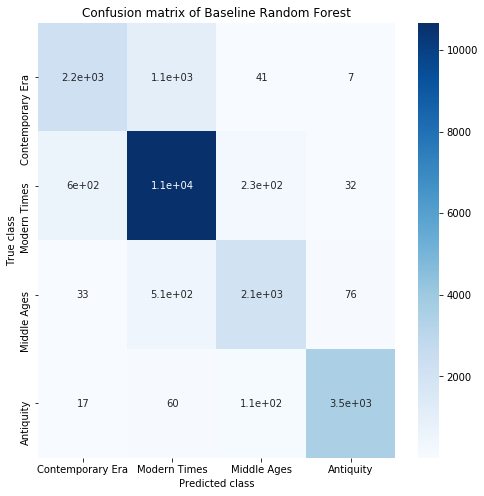

In [118]:
plot_confusion_matrix(rfc, X_test, y_test, model_name="Baseline Random Forest")